In [1]:
import librosa
import os

filepath = 'C:\\Users\\user\\Desktop\\MSBD5012 Project\\fma_small'

def load_metadata(path):
    metadata = []
    for f in os.listdir(path):
        #Enter into the subfolder in the fma_small dataset file
        for audio_f in os.listdir(os.path.join(path,f)):
            ext = os.path.splitext(audio_f)[1]
            if ext == '.mp3':
                metadata.append([f,os.path.join(path,f,audio_f)])
    return metadata

data = load_metadata(filepath)



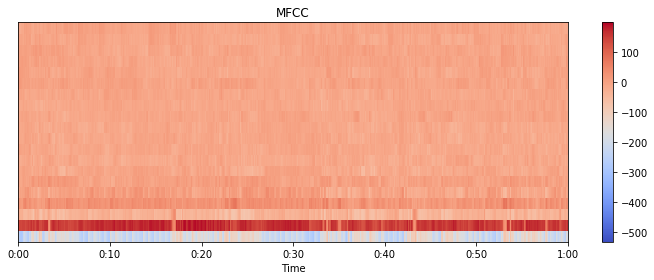

In [4]:
import matplotlib.pyplot as plt
import librosa.display
y, sr = librosa.load(data[7][1],sr=None,duration = 30)
mfccs = librosa.feature.mfcc(y=y, sr=sr)

plt.figure(figsize=(10, 4))
ax = librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show(ax)

In [9]:
hop_length = 512
oenv = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sr,hop_length=hop_length)
# Compute global onset autocorrelation
ac_global = librosa.autocorrelate(oenv, max_size=tempogram.shape[0])
ac_global = librosa.util.normalize(ac_global)
# Estimate the global tempo for display purposes
tempo = librosa.beat.tempo(onset_envelope=oenv, sr=sr,hop_length=hop_length)[0]

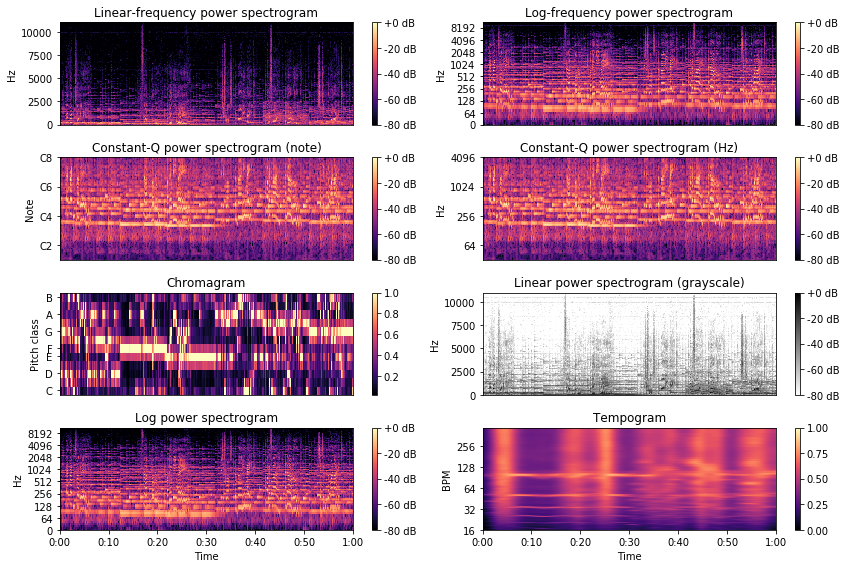

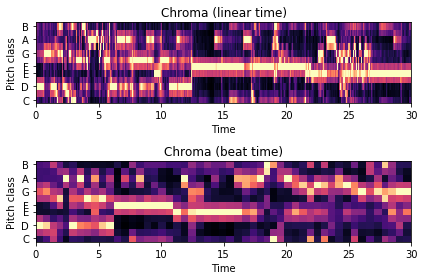

In [10]:
# Visualize an STFT power spectrum

import matplotlib.pyplot as plt
import numpy as np
#y, sr = librosa.load(librosa.util.example_audio_file())
plt.figure(figsize=(12, 8))

D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

# Or on a logarithmic scale

plt.subplot(4, 2, 2)
librosa.display.specshow(D, y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')

# Or use a CQT scale

CQT = librosa.amplitude_to_db(np.abs(librosa.cqt(y, sr=sr)), ref=np.max)
plt.subplot(4, 2, 3)
librosa.display.specshow(CQT, y_axis='cqt_note')
plt.colorbar(format='%+2.0f dB')
plt.title('Constant-Q power spectrogram (note)')

plt.subplot(4, 2, 4)
librosa.display.specshow(CQT, y_axis='cqt_hz')
plt.colorbar(format='%+2.0f dB')
plt.title('Constant-Q power spectrogram (Hz)')

# Draw a chromagram with pitch classes

C = librosa.feature.chroma_cqt(y=y, sr=sr)
plt.subplot(4, 2, 5)
librosa.display.specshow(C, y_axis='chroma')
plt.colorbar()
plt.title('Chromagram')

# Force a grayscale colormap (white -> black)

plt.subplot(4, 2, 6)
librosa.display.specshow(D, cmap='gray_r', y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear power spectrogram (grayscale)')

# Draw time markers automatically

plt.subplot(4, 2, 7)
librosa.display.specshow(D, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Log power spectrogram')

# Draw a tempogram with BPM markers

plt.subplot(4, 2, 8)
Tgram = librosa.feature.tempogram(y=y, sr=sr)
librosa.display.specshow(Tgram, x_axis='time', y_axis='tempo')
plt.colorbar()
plt.title('Tempogram')
plt.tight_layout()

# Draw beat-synchronous chroma in natural time

plt.figure()
tempo, beat_f = librosa.beat.beat_track(y=y, sr=sr, trim=False)
beat_f = librosa.util.fix_frames(beat_f, x_max=C.shape[1])
Csync = librosa.util.sync(C, beat_f, aggregate=np.median)
beat_t = librosa.frames_to_time(beat_f, sr=sr)
ax1 = plt.subplot(2,1,1)
librosa.display.specshow(C, y_axis='chroma', x_axis='time')
plt.title('Chroma (linear time)')
ax2 = plt.subplot(2,1,2, sharex=ax1)
librosa.display.specshow(Csync, y_axis='chroma', x_axis='time',
                         x_coords=beat_t)
plt.title('Chroma (beat time)')
plt.tight_layout()

### Data Preprocessing
**Corrupted Files (Dropped)** <br/>
\fma_small\099\099134.mp3 <br/>
\fma_small\108\108925.mp3 <br/>
\fma_small\133\133297.mp3 <br/>

In [ ]:
import librosa
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join

class FeatureExtractor:
    def __init__(self):
        self.data = None
        
    def extract(self,path):
        id = 0
        self.data = []
        file_data = [f for f in listdir(path)]
        for folder in file_data:
            for file in listdir(join(path,folder)):
                
                features = []
            
                id = id + 1
                songname = join(path,folder,file)
            
                print()
                print("Reading Song#{}: ".format(id) + songname + "...")
            
                x, sr = librosa.load(join(path,folder,file), sr=None, mono=True)
                stft = np.abs(librosa.stft(x, n_fft=2048, hop_length=512))
                tempo, beats = librosa.beat.beat_track(x, sr=sr)
                zcr = librosa.feature.zero_crossing_rate(x, frame_length=2048, hop_length=512)
                
                assert stft.shape[0] == 1 + 2048 // 2
                assert np.ceil(len(x)/512) <= stft.shape[1] <= np.ceil(len(x)/512)+1                
                del x
                
                chroma_stft = librosa.feature.chroma_stft(S=stft**2, n_chroma=12)
                rmse = librosa.feature.rmse(S=stft)
                cent = librosa.feature.spectral_centroid(S=stft)
                spec_bw = librosa.feature.spectral_bandwidth(S=stft)
                rolloff = librosa.feature.spectral_rolloff(S=stft)
                mel = librosa.feature.melspectrogram(sr=sr, S=stft**2)
                del stft
                mfcc = librosa.feature.mfcc(S=librosa.power_to_db(mel), n_mfcc=20)
                category = folder
        
                features.append(id)
                features.append(file)
                features.append(tempo)
                features.append(np.sum(beats))
                features.append(np.mean(chroma_stft))
                features.append(np.mean(rmse))
                features.append(np.mean(cent))
                features.append(np.mean(spec_bw))
                features.append(np.mean(rolloff))
                features.append(np.mean(zcr))
                for coefficient in mfcc:
                    features.append(np.mean(coefficient))
            
                self.data.append(features)

    def get_data(self):
        return self.data
        
# folder of the fma_small data
path = 'C:\\Users\\user\\Desktop\\MSBD5012 Project\\fma_small'
np.set_printoptions(threshold=np.inf)
extractor = FeatureExtractor()
extractor.extract(path)

pd.set_option('display.max_colwidth', -1)

heading = ['id', 'songname', 'tempo', 'beats', 'chromagram', 'rmse',
           'centroid', 'bandwidth', 'rolloff', 'zcr', 'mfcc1', 'mfcc2',
           'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9',
           'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15',
           'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20']
df = pd.DataFrame(extractor.get_data(), columns=heading)
df.drop(['id'], axis = 1, inplace = True)
df.to_csv('feature_extraction_2.csv')

In [9]:
df_feature = pd.read_csv('feature_extraction.csv')
df_track = pd.read_csv('tracks.csv', index_col = False)

df_track = df_track.loc[df_track['set subset'] == 'small']
df_track = df_track[['track_id','set subset','track genre_top']]
df_track['songname'] = df_track['track_id'].apply(lambda x: '0'*(6-len(str(x))) + str(x) + '.mp3')
df_track = df_track[['songname','track genre_top']]

result = pd.merge(df_feature, df_track, on='songname')
result.to_csv('feature_extraction(with label).csv', index = False)

del df_feature
del df_track

C:\Users\Juliana\Anaconda2\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (0,1,5,6,8,12,18,20,21,22,24,33,34,38,39,44,47,48,49,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [35]:
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

le = preprocessing.LabelEncoder()

df = pd.read_csv('feature_extraction(with label).csv')
X = df.iloc[:,1:29].values
y = df.iloc[:,29:30].values
label = [a[0] for a in y]
le.fit(label)

label = le.transform(label)

def appendInt(num):
    if num > 9:
        secondToLastDigit = str(num)[-2]
        if secondToLastDigit == '1':
            return 'th'
    lastDigit = num % 10
    if (lastDigit == 1):
        return 'st'
    elif (lastDigit == 2):
        return 'nd'
    elif (lastDigit == 3):
        return 'rd'
    else:
        return 'th'
    
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),algorithm="SAMME",n_estimators=200)
gnb = GaussianNB()

kf = KFold(n_splits=2, shuffle = True)
#clf = SVC(gamma='auto')

kf.get_n_splits(X)
no_fold = 0
for train_index, val_index in kf.split(X):
    no_fold += 1
    X_train_kf, X_validation_kf = np.array([X[i] for i in train_index]), np.array([X[i] for i in val_index])
    y_train_kf, y_validation_kf = np.array([label[i] for i in train_index]), np.array([label[i] for i in val_index])
    bdt.fit(X_train_kf,y_train_kf)
    gnb.fit(X_train_kf,y_train_kf)
    y_pred_ada = bdt.predict(X_validation_kf)
    y_pred_gnb = gnb.predict(X_validation_kf)
    acc_ada_score = accuracy_score(y_validation_kf, y_pred_ada)
    acc_gnb_score = accuracy_score(y_validation_kf, y_pred_gnb)
    print('The ' + str(no_fold) + appendInt(no_fold) + ' fold Accuracy of AdaBoost : {0:1.3f}'.format(acc_ada_score))
    print('The ' + str(no_fold) + appendInt(no_fold) + ' fold Accuracy of GaussianNB : {0:1.3f}'.format(acc_gnb_score))
    print()

The 1st fold Accuracy of AdaBoost : 0.397
The 1st fold Accuracy of GaussianNB : 0.360

The 2nd fold Accuracy of AdaBoost : 0.393
The 2nd fold Accuracy of GaussianNB : 0.368

